In [223]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
data.head()

,close
0,19270
1,19440
2,19390
3,19270
4,19330


In [224]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [225]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
12/12 [==============================] - 2s 48ms/step - loss: 0.0299 - val_loss: 0.0029
Epoch 2/100
12/12 [==============================] - 0s 32ms/step - loss: 0.0035 - val_loss: 0.0131
Epoch 3/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 7.4284e-04 - val_loss: 0.0033
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 7.1191e-04 - val_loss: 0.0045
Epoch 6/100
12/12 [==============================] - 0s 24ms/step - loss: 6.9927e-04 - val_loss: 0.0039
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 6.7740e-04 - val_loss: 0.0037
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 6.7287e-04 - val_loss: 0.0030
Epoch 9/100
12/12 [==============================] - 0s 27ms/step - loss: 6.7818e-04 - val_loss: 0.0034
Epoch 10/100
12/12 [==============================] - 0s 23ms/step - loss: 6

In [226]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


11/11 [==============================] - 0s 2ms/step


In [227]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 29ms/step
[[103153.664]
 [103812.74 ]
 [104431.93 ]
 [104953.86 ]
 [105369.33 ]
 [105708.99 ]
 [105985.555]
 [106183.766]
 [106309.195]
 [106390.945]
 [106459.17 ]
 [106531.39 ]
 [106608.97 ]
 [106686.164]
 [106762.19 ]
 [106840.85 ]
 [106920.29 ]
 [106986.45 ]
 [107010.74 ]
 [106976.53 ]
 [106895.18 ]
 [106800.17 ]
 [106736.55 ]
 [106755.46 ]
 [106861.03 ]
 [106998.38 ]
 [107113.37 ]
 [107196.75 ]
 [107259.65 ]
 [107312.62 ]]


In [228]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 3581.303539359022
MAPE trên tập test là: 3.3417390297907223 %
MSLE trên tập test là: 0.0019226307860459963


In [229]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

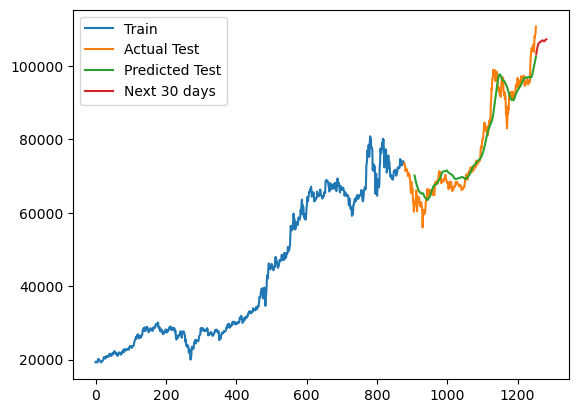

In [230]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 8/2)

In [231]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
data.head()

,close
0,19270
1,19440
2,19390
3,19270
4,19330


In [232]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [233]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
14/14 [==============================] - 1s 34ms/step - loss: 0.0362 - val_loss: 0.0115
Epoch 2/100
14/14 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 9.9270e-04 - val_loss: 0.0013
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 9.3828e-04 - val_loss: 0.0022
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss

In [234]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

7/7 [==============================] - 0s 4ms/step


In [235]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 35ms/step
[[93306.18 ]
 [93784.414]
 [94228.125]
 [94549.54 ]
 [94706.234]
 [94720.7  ]
 [94628.04 ]
 [94448.82 ]
 [94182.82 ]
 [93856.29 ]
 [93496.484]
 [93121.25 ]
 [92730.79 ]
 [92323.05 ]
 [91898.19 ]
 [91456.01 ]
 [90998.195]
 [90519.04 ]
 [90002.305]
 [89433.28 ]
 [88810.086]
 [88146.516]
 [87499.05 ]
 [86948.305]
 [86532.52 ]
 [86220.98 ]
 [85952.02 ]
 [85672.09 ]
 [85376.49 ]
 [85064.9  ]]


In [236]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 7860.674089552036
MAPE trên tập test là: 6.957422919106573 %
MSLE trên tập test là: 0.007581282102865916


In [237]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

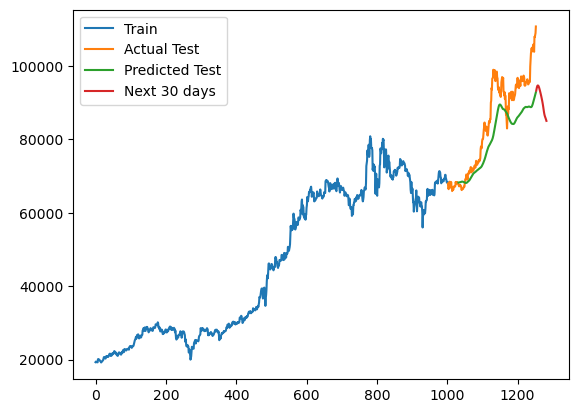

In [238]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 9/1)

In [239]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\Thuc-hanh\\Lab 4\\fpt_data_sheet.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume','ticker'])
data = data.reset_index(drop=True)
data.head()

,close
0,19270
1,19440
2,19390
3,19270
4,19330


In [240]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.9)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [241]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
16/16 [==============================] - 2s 58ms/step - loss: 0.0382 - val_loss: 0.0313
Epoch 2/100
16/16 [==============================] - 1s 37ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 3/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0011 - val_loss: 8.7260e-04
Epoch 4/100
16/16 [==============================] - 1s 45ms/step - loss: 9.7377e-04 - val_loss: 0.0012
Epoch 5/100
16/16 [==============================] - 1s 43ms/step - loss: 9.3025e-04 - val_loss: 9.4398e-04
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/100
16/16 [==============================] - 1s 44ms/step - loss: 9.4410e-04 - val_loss: 0.0019
Epoch 8/100
16/16 [==============================] - 1s 32ms/step - loss: 9.2716e-04 - val_loss: 0.0017
Epoch 9/100
16/16 [==============================] - 1s 43ms/step - loss: 8.6546e-04 - val_loss: 0.0013
Epoch 10/100
16/16 [==============================] - 1s 43ms/step - los

In [242]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

3/3 [==============================] - 0s 5ms/step


In [243]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 30ms/step
[[ 98710.836]
 [ 99390.62 ]
 [ 99971.96 ]
 [100363.78 ]
 [100535.97 ]
 [100530.57 ]
 [100441.61 ]
 [100306.88 ]
 [100106.51 ]
 [ 99854.96 ]
 [ 99580.016]
 [ 99306.37 ]
 [ 99038.36 ]
 [ 98765.8  ]
 [ 98478.22 ]
 [ 98178.33 ]
 [ 97863.164]
 [ 97510.83 ]
 [ 97098.84 ]
 [ 96607.266]
 [ 96029.72 ]
 [ 95427.93 ]
 [ 94896.93 ]
 [ 94511.71 ]
 [ 94289.01 ]
 [ 94164.7  ]
 [ 94009.85 ]
 [ 93760.93 ]
 [ 93447.98 ]
 [ 93112.28 ]]


In [244]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 6416.575809759942
MAPE trên tập test là: 5.799747176966843 %
MSLE trên tập test là: 0.0045034063820088115


In [245]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

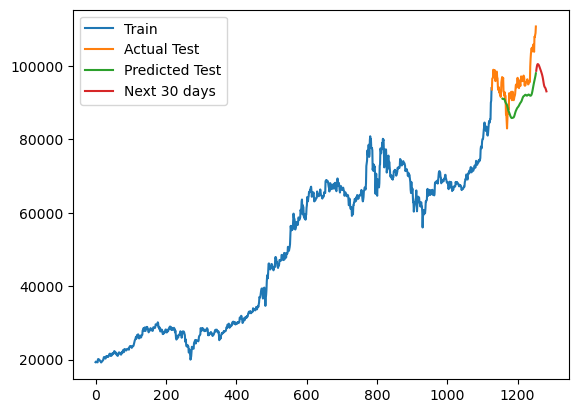

In [246]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()